<a href="https://colab.research.google.com/github/hadjerseddik/Crop_classification/blob/main/Train/FlowersDataSet/Test_experiments/ResNet101Arch_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)
 
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout
 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import optimizers
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models
from sklearn.model_selection import train_test_split
 
import datetime
import numpy as np
import glob
import os
import pandas as pd

2.5.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datasetpath = '/content/drive/MyDrive/flowers'
lists = os.listdir(datasetpath)
labels = []
file_lst = []

for folder in lists:
    files = os.listdir(datasetpath +"/"+folder)
    if(folder != 'background'):   
      files = [folder+'/'+file  for file in files]
      file_lst.extend(files)
      labels.extend([folder.split(sep='___')[0] for i in range(len(files))])
#print(len(file_lst))
#print(len(labels))
df = pd.DataFrame(list(zip(file_lst,labels)),columns =["path","label"])
print(df)

                                    path  label
0      daisy/3703643767_dee82cdef9_n.jpg  daisy
1     daisy/34261196280_aa99186136_n.jpg  daisy
2      daisy/4258408909_b7cc92741c_m.jpg  daisy
3      daisy/4229503616_9b8a42123c_n.jpg  daisy
4     daisy/34664107325_701d5c6f08_n.jpg  daisy
...                                  ...    ...
4312   tulip/9378657435_89fabf13c9_n.jpg  tulip
4313   tulip/9446982168_06c4d71da3_n.jpg  tulip
4314   tulip/9831362123_5aac525a99_n.jpg  tulip
4315   tulip/9030467406_05e93ff171_n.jpg  tulip
4316   tulip/9870557734_88eb3b9e3b_n.jpg  tulip

[4317 rows x 2 columns]


In [ ]:
train_df, validation_df = train_test_split(df, test_size=0.3,shuffle = True, random_state=42)
print(train_df )
print(validation_df)

                                        path      label
3024        rose/5001856089_4cf8e9c818_n.jpg       rose
927      sunflower/3865206264_5d81584bba.jpg  sunflower
612        daisy/8021540573_c56cf9070d_n.jpg      daisy
1023  sunflower/20871601265_daa4be4291_n.jpg  sunflower
3470       tulip/3454461550_64d6e726bf_m.jpg      tulip
...                                      ...        ...
3444       tulip/3502974120_9f1eceaf8b_n.jpg      tulip
466          daisy/8681746439_d6beeefbf9.jpg      daisy
3092        rose/5182167964_9d1a0be0b8_n.jpg       rose
3772          tulip/134143359_71fa8dd9a4.jpg      tulip
860    sunflower/2694860538_b95d60122c_m.jpg  sunflower

[3021 rows x 2 columns]
                                       path      label
3800     tulip/15049902081_dd85361f8c_m.jpg      tulip
2014     dandelion/510897767_918260db93.jpg  dandelion
1923  dandelion/2521827947_9d237779bb_n.jpg  dandelion
2533   dandelion/15139657325_74031c44fc.jpg  dandelion
3747     tulip/15029962436_3

In [ ]:
batch_size = 32
image_size=(224,224)
nb_epoch = 15

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
                  dataframe=train_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/drive/MyDrive/flowers',
                  target_size=image_size,
                  batch_size=batch_size
                  )

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
                  dataframe=validation_df,
                  x_col="path",
                  y_col="label",
                  directory= '/content/drive/MyDrive/flowers',
                  target_size=image_size,
                  batch_size=batch_size
                  ) 

Found 3021 validated image filenames belonging to 5 classes.
Found 1296 validated image filenames belonging to 5 classes.


In [ ]:
print(train_generator.class_indices)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [ ]:
class_number = 5
def build_model_graph(class_number=class_number):
  base_model = ResNet101(weights='imagenet', include_top=False,input_shape = (224,224,3))
  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  #x = Dense(512, activation='relu')(x)
  x = Dropout(0.3)(x)
  x = Dense(256, activation='relu')(x)
  predictions = Dense(class_number, activation='softmax')(x)
  model = Model(base_model.input, predictions)

  return model

In [ ]:
model = build_model_graph()
print(model.summary())

171450368/171446536 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.869151 to fit



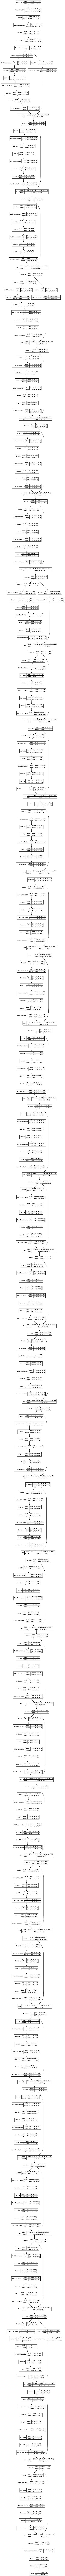

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
model.compile(optimizer=optimizers.SGD(learning_rate=1e-3, momentum=0.9), 
              loss='categorical_crossentropy' ,
              metrics = ['accuracy']
              )

In [ ]:
hist=model.fit(train_generator,
          epochs=nb_epoch,
          validation_data=validation_generator
         ) 

Epoch 1/15
95/95 [==============================] - 1238s 13s/step - loss: 0.7171 - accuracy: 0.7276 - val_loss: 2.3819 - val_accuracy: 0.1813
Epoch 2/15
95/95 [==============================] - 64s 669ms/step - loss: 0.2111 - accuracy: 0.9308 - val_loss: 4.1799 - val_accuracy: 0.1890
Epoch 3/15
95/95 [==============================] - 63s 661ms/step - loss: 0.0957 - accuracy: 0.9709 - val_loss: 4.7681 - val_accuracy: 0.1759
Epoch 4/15
95/95 [==============================] - 63s 661ms/step - loss: 0.0491 - accuracy: 0.9881 - val_loss: 3.9882 - val_accuracy: 0.1698
Epoch 5/15
95/95 [==============================] - 63s 664ms/step - loss: 0.0317 - accuracy: 0.9947 - val_loss: 3.1809 - val_accuracy: 0.2446
Epoch 6/15
95/95 [==============================] - 63s 663ms/step - loss: 0.0220 - accuracy: 0.9964 - val_loss: 2.6017 - val_accuracy: 0.3742
Epoch 7/15
95/95 [==============================] - 63s 663ms/step - loss: 0.0167 - accuracy: 0.9957 - val_loss: 1.5164 - val_accuracy: 0.5694

In [ ]:
results = '/content/drive/MyDrive/PlantClassification/Results'
os.mkdir(results) 

In [ ]:
flowersDataSet = '/content/drive/MyDrive/PlantClassification/Results/flowersDataSet'
os.mkdir(flowersDataSet) 

In [ ]:
ResNet101Arch = '/content/drive/MyDrive/PlantClassification/Results/flowersDataSet/ResNet101Arch'
os.mkdir(ResNet101Arch) 

In [ ]:
target_dir = '/content/drive/MyDrive/PlantClassification/Results/flowersDataSet/ResNet101Arch'
architecture_name = "ResNet101Arch"
#ct = str(datetime.datetime.now())
model.save(target_dir+'/'+architecture_name+'.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
print(hist.history)

{'loss': [0.7171370983123779, 0.2110523134469986, 0.09566397964954376, 0.04905078560113907, 0.03165537491440773, 0.0220396239310503, 0.01665620505809784, 0.013416344299912453, 0.011327952146530151, 0.008875598199665546, 0.007832848466932774, 0.007038791198283434, 0.006582361180335283, 0.006150927394628525, 0.005855409894138575], 'accuracy': [0.7275736331939697, 0.9308176040649414, 0.9708705544471741, 0.9880834221839905, 0.9947037696838379, 0.9963588118553162, 0.9956967830657959, 0.998344898223877, 0.9980139136314392, 0.9986759424209595, 0.9986759424209595, 0.9993379712104797, 0.9980139136314392, 0.9990069270133972, 0.9993379712104797], 'val_loss': [2.3819077014923096, 4.179871559143066, 4.768110752105713, 3.9881749153137207, 3.1809346675872803, 2.601743698120117, 1.5164109468460083, 0.9262514710426331, 0.6278170347213745, 0.4090200364589691, 0.3221588730812073, 0.30691900849342346, 0.3004516661167145, 0.3145804703235626, 0.301824688911438], 'val_accuracy': [0.18132716417312622, 0.18904

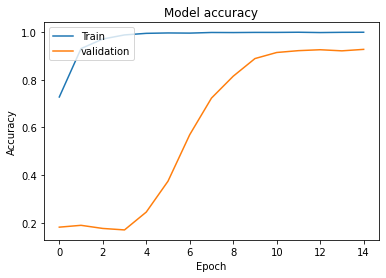

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show()

In [ ]:
hist = pd.DataFrame(hist.history)

In [ ]:
hist_csv_file = '/content/drive/MyDrive/PlantClassification/Results/flowersDataSet/ResNet101Arch/history.csv'
with open(hist_csv_file, mode='w') as f:
    hist.to_csv(f)

In [ ]:
train_df.to_csv('/content/drive/MyDrive/PlantClassification/Results/flowersDataSet/train.csv')

In [ ]:
validation_df.to_csv('/content/drive/MyDrive/PlantClassification/Results/flowersDataSet/validation.csv')

In [ ]:
model= model_load()

In [ ]:
img_path = '/content/drive/MyDrive/flowers/daisy/100080576_f52e8ee070_n.jpg'

img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = (img_batch)*(1./255)

result = model.predict(img_preprocessed)
print(result)

[[9.9985707e-01 7.9164245e-05 3.3498294e-05 2.2879742e-05 7.3540955e-06]]


In [ ]:
index_max=result.argmax(axis=-1)
print(index_max)

[0]


In [ ]:
print(train_generator.class_indices)

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


In [ ]:
model = load_model('/content/drive/MyDrive/PlantClassification/Results/flowersDataSet/ResNet101Arch/ResNet101Arch.h5')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________